In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

In [ ]:
#library
import pandas as pd
import regex as re
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pickle
import plotly.express as px
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from keras.models import load_model

## Dataset

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/binar-data-science/Platinum Challenge/train_preprocess.tsv.txt',sep='	',header=None)

In [ ]:
df.columns=['text','label']

In [ ]:
df['text']

0        warung ini dimiliki oleh pengusaha pabrik tahu...
1        mohon ulama lurus dan k212 mmbri hujjah partai...
2        lokasi strategis di jalan sumatera bandung . t...
3        betapa bahagia nya diri ini saat unboxing pake...
4        duh . jadi mahasiswa jangan sombong dong . kas...
                               ...                        
10995                                         tidak kecewa
10996    enak rasa masakan nya apalagi kepiting yang me...
10997          hormati partai-partai yang telah berkoalisi
10998    pagi pagi di tol pasteur sudah macet parah , b...
10999    meskipun sering belanja ke yogya di riau junct...
Name: text, Length: 11000, dtype: object

In [ ]:
df.isna().sum()

text     0
label    0
dtype: int64

In [ ]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

## Preprocessing

In [ ]:
df_stopwordbahasa=pd.read_csv('/content/drive/MyDrive/binar-data-science/Platinum Challenge/stopwordbahasa.csv',header=None)
df_stopwordbahasa.columns=['stopword']

In [ ]:
df_kamusalay = pd.read_csv('/content/drive/MyDrive/binar-data-science/Platinum Challenge/new_kamusalay.csv', encoding='latin-1', sep = ';', names=['Alay','Normal'])

In [ ]:
#cleansing
def preprocess_text(text):
    # lower text
    text = text.lower()

    # remove byte emoticons and special characters
    text = re.sub(r'\\x[\da-fA-F]{2}', '', text)

    # only allow characters from a to z (both upper and lower case)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)

    # remove excessive white space
    text = re.sub(r'\s+', ' ', text)

    # remove digit or numbers
    text = re.sub(r"\b\d+\b", " ", text)

    # remove digit from string
    text = re.sub("\S*\d\S*", "", text).strip()

    return text

#removing stopwords
stopwords = df_stopwordbahasa['stopword'].tolist()
def remove_stopwords(text):
    list_stopwords = text.split()
    return ' '.join([text for text in list_stopwords if text not in stopwords])

#normalization
kamus_alay = dict(zip(df_kamusalay['Alay'], df_kamusalay['Normal']))
def normalize(text):
    for word in kamus_alay:
        return ' '.join([kamus_alay[word] if word in kamus_alay else word for word in text.split(' ')])

#stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stem_text(text):
    return stemmer.stem(text)

In [ ]:
def cleansing_text(text):
    text = preprocess_text(text)
    text = remove_stopwords(text)
    text = normalize(text)
    text = stem_text(text)
    return text

In [ ]:
df['text_baru'] = df['text'].apply(cleansing_text)

In [ ]:
df.text_baru.to_list()[0:5]

['warung milik usaha pabrik puluh kenal putih bandung kualitas padu ahli masak padu kretivitas warung saji menu utama bahan tambah menu ayam selera indonesia harga jangkau lewat bletoka kalah asli tegal',
 'mohon ulama lurus beri hujjah partai diwlh suara islam pecah pecah',
 'lokasi strategis jalan sumatra bandung nyaman sofa lantai paella enak pas makan minum bir dingin appetiser enak enak',
 'betapa bahagia unboxing paket barang bagus tetap beli',
 'aduh mahasiswa sombong kasih kartu kuning ajar usah politik selesai kuliah politik telat dasar mahasiswa']

## Sentiment Label

In [ ]:
neg = df.loc[df['label'] == 'negative'].text_baru.tolist()
neu = df.loc[df['label'] == 'neutral'].text_baru.tolist()
pos = df.loc[df['label'] == 'positive'].text_baru.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('Pos: %s, Neu: %s, Neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


## Feature Extraction

In [ ]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('tokenizer.pickle has created!')

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [ ]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

y_labels.pickle has created!


## Split Data

In [ ]:
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

## Training

In [ ]:
embed_dim = 64
units = 128

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.3))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 64)            6400000   
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 6499203 (24.79 MB)
Trainable params: 6499203 (24.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
69/69 [==============================] - 25s 319ms/step - loss: 0.7418 - accuracy: 0.6859 - val_loss: 0.5615 - val_accuracy: 0.7636
Epoch 2/5
69/69 [==============================] - 20s 289ms/step - loss: 0.4622 - accuracy: 0.8002 - val_loss: 0.4717 - val_accuracy

## Evaluation

In [ ]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai')
print(matrix_test)

69/69 [==============================] - 2s 27ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       685
           1       0.75      0.72      0.73       233
           2       0.88      0.91      0.89      1282

    accuracy                           0.84      2200
   macro avg       0.81      0.79      0.80      2200
weighted avg       0.84      0.84      0.84      2200



## Cross Validation

In [ ]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 64
units = 128

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.3))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=1)

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Epoch 1/5
69/69 [==============================] - 23s 289ms/step - loss: 0.7420 - accuracy: 0.6853 - val_loss: 0.5638 - val_accuracy: 0.7686
Epoch 2/5
69/69 [==============================] - 19s 279ms/step - loss: 0.4633 - accuracy: 0.8055 - val_loss: 0.4431 - val_accuracy: 0.8195
Epoch 3/5
69/69 [==============================] - 21s 306ms/step - loss: 0.2988 - accuracy: 0.8869 - val_loss: 0.3991 - val_accuracy: 0.8455
Epoch 4/5
69/69 [==============================] - 19s 280ms/step - loss: 0.2095 - accuracy: 0.9253 - val_loss: 0.4411 - val_accuracy: 0.8373
Epoch 5/5
69/69 [==============================] - 2s 27ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       685
           1       0.66      0.77      0.71       233
           2       0.90      0.90      0.90      1282

    accuracy                           0.84      2200
   macro avg       0.79      0.81      0.80      2200
weighted avg       0.85    

# Model Evaluation

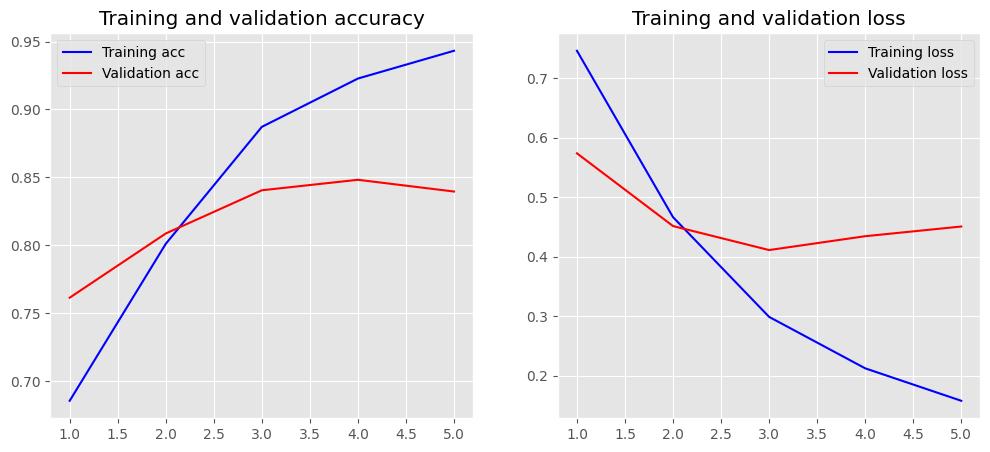

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) +1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

%matplotlib inline
plot_history(history)

## Save Model

In [ ]:
model.save('model.h5')
print('Model has created!')

Model has created!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predict

In [ ]:
input_text = """
syukur..,,;,;
"""

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing_text(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ',text[0])
print('Sentiment: ',sentiment[polarity])

1/1 [==============================] - 1s 650ms/step
Text:  syukur
Sentiment:  positive


In [ ]:
input_text = """
sombong..,,;,;
"""

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing_text(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ',text[0])
print('Sentiment: ',sentiment[polarity])

1/1 [==============================] - 0s 475ms/step
Text:  sombong
Sentiment:  negative
